# Readme
Tут два файла истории EURUSD 1 за 2016 год часовой тик. 2016й полньій год можна использовать для обучения, а часть 2017-го для валидации, я включил 2.5 месяца в 2017й.

Данньіе в файлах идут как Local time, Open,High, Low,Close, Volume

Не знаю насколько тьі знаком с такими данньіми. Коротко, то Open - цена в начале тика данньіх, Close - в конце периода, ну и High Low внутренние колебания наибольшая и наименьшая цена
В принципе все 4, и также Volume, обьем продаж за етот период, важньі. Но для простотьі можем пока что брать только Open цену для обучального набора примеров

Тут Gnuplot скрипт для примера чтобьі рисовать Candlesticks и етих данньіх

Можна например разбить данньіе на бегущее окно 24 Open price для входа в сеть, и скажем 5 последующих для вьіхода сети, т.е. предсказание на 5 тиков в будущее
Таким образом learning set будет иметь 8754 примера

# Contents:
## [Data Wrangling](#DWr)
- Import packages and read the data
- [Plot the data](#PlotData)

## [Formulate the ML Model](#Model)
- Split input data into [batches](#Batches) (learning windows)
- The Olexander's [moving average model](#MAverage) (TODO)
- Make a standard [ARIMA based model](#ARIMA) (TODO)
- Make a simple [LSTM network](#LSTM) (TODO)
- Combine [LSTM and ARIMA](#LSTM+ARIMA) (TODO)
- Improve the LSTM by applying a [wavelet transformation](#Wavelet) (TODO)

## Data Wrangling<a id='DWr'></a>

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Read the input files
EURUSD_1H_2016_df = pd.read_table('EURUSD_1H_2016.txt',sep=',')

In [4]:
# Preview the dataframe
EURUSD_1H_2016_df

,Local time,Open,High,Low,Close,Volume
0,01.01.2016 00:00:00.000,1.08564,1.08564,1.08564,1.08564,0.0
1,01.01.2016 01:00:00.000,1.08564,1.08564,1.08564,1.08564,0.0
2,01.01.2016 02:00:00.000,1.08564,1.08564,1.08564,1.08564,0.0
3,01.01.2016 03:00:00.000,1.08564,1.08564,1.08564,1.08564,0.0
4,01.01.2016 04:00:00.000,1.08564,1.08564,1.08564,1.08564,0.0
...,...,...,...,...,...,...
8778,31.12.2016 19:00:00.000,1.05150,1.05150,1.05150,1.05150,0.0
8779,31.12.2016 20:00:00.000,1.05150,1.05150,1.05150,1.05150,0.0
8780,31.12.2016 21:00:00.000,1.05150,1.05150,1.05150,1.05150,0.0
8781,31.12.2016 22:00:00.000,1.05150,1.05150,1.05150,1.05150,0.0


In [7]:
# check for nan values 
EURUSD_1H_2016_df.isna().sum()

Local time    0
Open          0
High          0
Low           0
Close         0
Volume        0
dtype: int64

In [10]:
type(EURUSD_1H_2016_df)

pandas.core.frame.DataFrame

### Plot the data<a id='PlotData'></a>

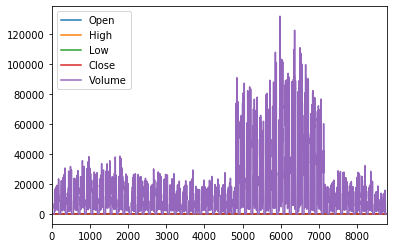

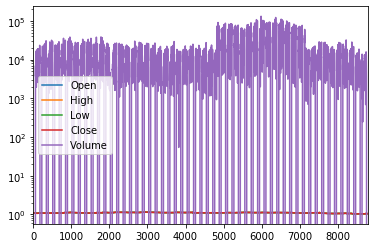

In [15]:
# Plot everything as a line
EURUSD_1H_2016_df.plot.line();
# Plot in log scale
EURUSD_1H_2016_df.plot.line(logy=True);

**`Volume` is much larger than anything else.**

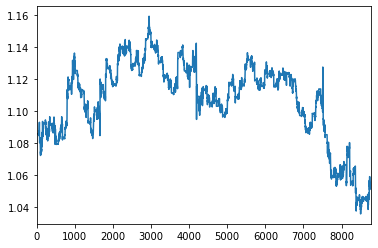

In [20]:
# Plot only 'Open'
EURUSD_1H_2016_df.Open.plot.line();

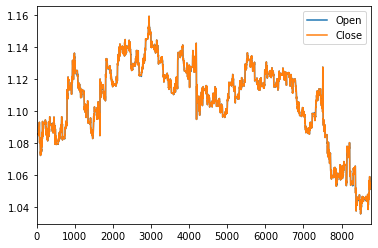

In [26]:
# Plot 'Open' and 'Close'
EURUSD_1H_2016_df.plot.line(y={'Open','Close'});

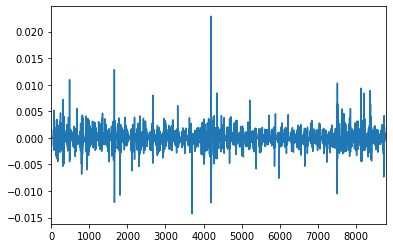

In [28]:
# Plot the difference of 'Open' and 'Close'
(EURUSD_1H_2016_df.Open - EURUSD_1H_2016_df.Close).plot.line();

**`Open` almost coincides with `Close`.**

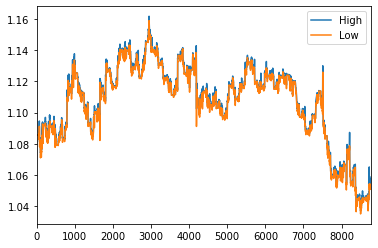

In [30]:
# Plot 'High' and 'Low'
EURUSD_1H_2016_df.plot.line(y={'High','Low'});

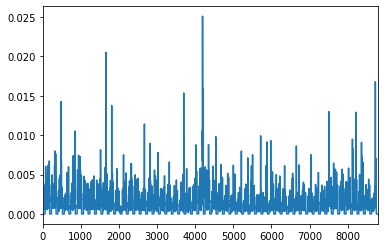

In [31]:
# Plot the difference of 'High' and 'Low'
(EURUSD_1H_2016_df.High - EURUSD_1H_2016_df.Low).plot.line();

## Formlate the ML Model<a id='Model'></a>

### Split input data into batches (learning windows)<a id='Batches'></a>

In [33]:
# Get 'Open'
EURUSD_1H_2016_df.Open

0       1.08564
1       1.08564
2       1.08564
3       1.08564
4       1.08564
         ...   
8778    1.05150
8779    1.05150
8780    1.05150
8781    1.05150
8782    1.05150
Name: Open, Length: 8783, dtype: float64

In [39]:
# Get 'Open' by index
print('Open[0]:\n',EURUSD_1H_2016_df.Open[0])
print('Open[8782]:\n',EURUSD_1H_2016_df.Open[8782])
# Get a slice
print('Open[100:110]:\n',EURUSD_1H_2016_df.Open[100:110])

Open[0]:
 1.08564
Open[8782]:
 1.0515
Open[100:110]:
 100    1.07559
101    1.07516
102    1.07421
103    1.07391
104    1.07216
105    1.07422
106    1.07455
107    1.07338
108    1.07436
109    1.07500
Name: Open, dtype: float64


In [57]:
# Можна например разбить данньіе на бегущее окно 24 Open price для входа в сеть, 
# и скажем 5 последующих для вьіхода сети, т.е. предсказание на 5 тиков в будущее.
# Таким образом learning set будет иметь 8754 примера
def get_slices(data, point, run_win=24, fwd_win=5):
    
    # Input:
        # data: a column in a data frame to slice,
        # point: index of the entering point for the slice, 
        # run_win: backward looking window,
        # fwd_win: forward looking window
        
    # Output:
        # run: backward slice
        # fwd: forward slice
    start = point - run_win 
    stop  = point + fwd_win
    
    run = data[start:point+1]
    fwd = data[      point+1:stop+1]
    
    return run, fwd

In [58]:
# Test `get_slices`
data = EURUSD_1H_2016_df
get_slices(data,42,fwd_win=3)

(                 Local time     Open     High      Low    Close  Volume
 18  01.01.2016 18:00:00.000  1.08564  1.08564  1.08564  1.08564     0.0
 19  01.01.2016 19:00:00.000  1.08564  1.08564  1.08564  1.08564     0.0
 20  01.01.2016 20:00:00.000  1.08564  1.08564  1.08564  1.08564     0.0
 21  01.01.2016 21:00:00.000  1.08564  1.08564  1.08564  1.08564     0.0
 22  01.01.2016 22:00:00.000  1.08564  1.08564  1.08564  1.08564     0.0
 23  01.01.2016 23:00:00.000  1.08564  1.08564  1.08564  1.08564     0.0
 24  02.01.2016 00:00:00.000  1.08564  1.08564  1.08564  1.08564     0.0
 25  02.01.2016 01:00:00.000  1.08564  1.08564  1.08564  1.08564     0.0
 26  02.01.2016 02:00:00.000  1.08564  1.08564  1.08564  1.08564     0.0
 27  02.01.2016 03:00:00.000  1.08564  1.08564  1.08564  1.08564     0.0
 28  02.01.2016 04:00:00.000  1.08564  1.08564  1.08564  1.08564     0.0
 29  02.01.2016 05:00:00.000  1.08564  1.08564  1.08564  1.08564     0.0
 30  02.01.2016 06:00:00.000  1.08564  1.08564  1.0

### The Olexander's moving average model<a id='MAverage'></a> (TODO)

### Make a standard ARIMA based model<a id='ARIMA'></a> (TODO)
We adapt the model formulated [here](https://medium.com/@cdabakoglu/time-series-forecasting-arima-lstm-prophet-with-python-e73a750a9887).

In [55]:
# Install pmdarima https://anaconda.org/saravji/pmdarima
# From jupyter notebook, sending "yes", if required
! conda install -c saravji pmdarima --y

Solving environment: done

## Package Plan ##

  environment location: /home/vb/anaconda3

  added / updated specs:
    - pmdarima


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pmdarima-1.2.0             |   py37hc689a4b_7         353 KB  saravji
    ------------------------------------------------------------
                                           Total:         353 KB

The following NEW packages will be INSTALLED:

  pmdarima           saravji/linux-64::pmdarima-1.2.0-py37hc689a4b_7



pmdarima-1.2.0       | 353 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [56]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima                        
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
#warnings.filterwarnings("ignore")

/home/vb/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/home/vb/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


**(!) One needs to make sure that the Panda Series object has a DateTime index with inferred frequency, see [this](https://stackoverflow.com/questions/64025453/attributeerror-rangeindex-object-has-no-attribute-inferred-freq).** 

In [63]:
EURUSD_1H_2016_df.index

RangeIndex(start=0, stop=8783, step=1)

**Our indexes are just numbers => convert the column `Local time` to index, see [this](https://stackoverflow.com/questions/37610983/how-set-column-as-date-index).**

In [64]:
# Convert to datetime
EURUSD_1H_2016_df['Local time'] = pd.to_datetime(EURUSD_1H_2016_df['Local time'])
EURUSD_1H_2016_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8783 entries, 0 to 8782
Data columns (total 6 columns):
Local time    8783 non-null datetime64[ns]
Open          8783 non-null float64
High          8783 non-null float64
Low           8783 non-null float64
Close         8783 non-null float64
Volume        8783 non-null float64
dtypes: datetime64[ns](1), float64(5)
memory usage: 411.8 KB


In [65]:
# Set the index
EURUSD_1H_2016_df.set_index('Local time', inplace=True)
EURUSD_1H_2016_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8783 entries, 2016-01-01 00:00:00 to 2016-12-31 23:00:00
Data columns (total 5 columns):
Open      8783 non-null float64
High      8783 non-null float64
Low       8783 non-null float64
Close     8783 non-null float64
Volume    8783 non-null float64
dtypes: float64(5)
memory usage: 411.7 KB


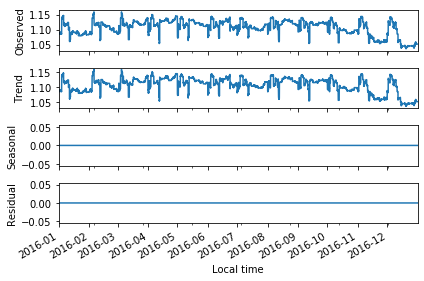

In [82]:
a = seasonal_decompose(EURUSD_1H_2016_df["Close"], model = "add",freq=1)
a.plot();

In [83]:
auto_arima(EURUSD_1H_2016_df['Close'], seasonal=True, 
           m=12,max_p=7, max_d=5,max_q=7, max_P=4, max_D=4,max_Q=4).summary()

/home/vb/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/vb/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/vb/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/vb/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/vb/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters fou

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 8783
Model:               SARIMAX(3, 1, 0)   Log Likelihood               47476.014
Date:                Sat, 23 Jan 2021   AIC                         -94942.028
Time:                        17:39:37   BIC                         -94906.626
Sample:                             0   HQIC                        -94929.967
                               - 8783                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -3.837e-06   1.18e-05     -0.325      0.745    -2.7e-05    1.93e-05
ar.L1          0.0389      0.004      9.963      0.000       0.031       0.047
ar.L2          0.0290      0.004      6.862      0.000       0.021       0.037
ar.L3         -0.0354      0.004     -8.497      0.000      -0.044      -0.027
sigma2       1.18e-06   3.95e-09    298.634      0.000    1.17e-06    1.19e-06
===================================================================================
Ljung-Box (Q):                       85.84   Jarque-Bera (JB):            747214.83
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                            -0.89
Prob(H) (two-sided):                  0.00   Kurtosis:                        48.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [92]:
df = EURUSD_1H_2016_df
train_data = df[:len(df)-300]
test_data = df[len(df)-300:]
arima_model = SARIMAX(train_data['Close'], order = (3,1,0))#, seasonal_order = (4,0,3,12))
arima_result = arima_model.fit()
arima_result.summary()

/home/vb/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  Close   No. Observations:                 8483
Model:               SARIMAX(3, 1, 0)   Log Likelihood               45820.590
Date:                Sat, 23 Jan 2021   AIC                         -91633.180
Time:                        17:54:54   BIC                         -91604.997
Sample:                             0   HQIC                        -91623.561
                               - 8483                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0438      0.004     11.032      0.000       0.036       0.052
ar.L2          0.0307      0.004      7.170      0.000       0.022       0.039
ar.L3         -0.0351      0.004     -8.373      0.000      -0.043      -0.027
sigma2      1.189e-06   4.02e-09    296.003      0.000    1.18e-06     1.2e-06
===================================================================================
Ljung-Box (Q):                       82.18   Jarque-Bera (JB):            731547.84
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                            -0.97
Prob(H) (two-sided):                  0.00   Kurtosis:                        48.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [93]:
arima_pred = arima_result.predict(start = len(train_data), end = len(df)-1, typ="levels").rename("ARIMA Predictions")
arima_pred

/home/vb/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


8483    1.040242
8484    1.040236
8485    1.040306
8486    1.040314
8487    1.040316
          ...   
8778    1.040314
8779    1.040314
8780    1.040314
8781    1.040314
8782    1.040314
Name: ARIMA Predictions, Length: 300, dtype: float64

TypeError: index type not supported

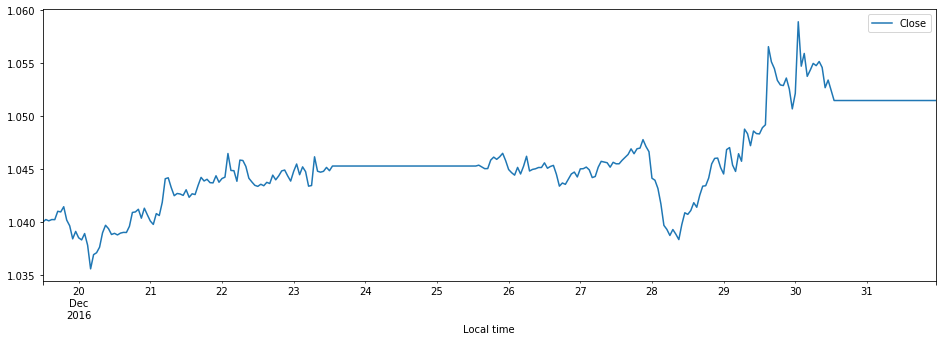

In [94]:
test_data['Close'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

In [95]:
arima_rmse_error = rmse(test_data['Close'], arima_pred)
arima_mse_error = arima_rmse_error**2
mean_value = df['Close'].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

MSE Error: 4.4471755150633046e-05
RMSE Error: 0.006668714655061577
Mean: 1.1066610668336554


### Make a simple LSTM network<a id='LSTM'></a> (TODO)

### Combine LSTM and ARIMA<a id='LSTM+ARIMA'></a> (TODO)
- [Demand Forecasting for Platelet Usage: from Univariate Time Series to Multivariate Models](https://arxiv.org/pdf/2101.02305.pdf)

### Improve the LSTM by applying a wavelet transformation<a id='Wavelet'></a> (TODO)
- A blog about [Wavelets](https://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/?fbclid=IwAR2w32L-CDuMkAzF5NrmqmsWZu8NHmgW-bt8Em1124AQ58r7AMHam9MQdFU)